# MLB Predictor Project

Group 21, Plotters for Success

Gerardo Skrut, Victor Gikunda, Mathew Huang

In [17]:
import pandas as pd
import seaborn as sn
import numpy as np
import csv
from datetime import datetime
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 

# Import Statements for Neural Networks
import sklearn as sk
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
import pickle
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, accuracy_score



## Data Cleaning

Prior to importing the data, we cleaned and explored the existing data.

Finally, After we consolidated two datasets with pitching and batting, we are going to separate each portion to inputs and outputs respectively. 

Our inputs overall would include Left Field, Right Field, and Centerfield Distance, Maximum and minimum wall height, Day/night, Attendance, Precipitation, Sky Condition, Temperature, Wind Direction, and Wind Speed. 

For Pitching specifically, we will be using the pitcher's **Season ERA** from the 2023 Season. 

For Batting Specifically, we will be using the batter's **Season Batting Average** from the 2023 Season.

Our outputs would be game specific statistics. 

For Pitching, we would have the number of Hits Allowed, Runs Allowed, Earned Runs, Walks Given, Hit by Pitches, and Wild Pitches.

For Batting, we would have the number of Hits, Doubles, Triples, Home Runs, RBIs, Walks, and Strikeouts. 

### Ballpark Dataset Cleaning

In [700]:
# Load ballparks data
data = pd.read_csv('ballparks.csv')

# Filter for relevant columns
columns_to_keep = ['team_name', 'ballpark', 'left_field', 'center_field', 'right_field', 'min_wall_height', 'max_wall_height']
data_filtered = data[columns_to_keep]

# Calculate average for numeric columns
average_values = data_filtered[['left_field', 'center_field', 'right_field', 'min_wall_height', 'max_wall_height']].mean()

# Print the average values
print("Average Column Values:")
print(average_values)

# Save the filtered data
data_filtered.to_csv('2023_filtered_ballpark_data.csv', index=False)


Average Column Values:
left_field         331.833333
center_field       404.166667
right_field        328.333333
min_wall_height      7.553333
max_wall_height     14.266667
dtype: float64


### Game Information Data Cleaning

In [702]:
# Load game info data
data = pd.read_csv('2023gameinfo.csv')

# Filter for relevant columns
columns_to_keep = ['gid', 'daynight', 'attendance', 'precip', 'sky', 'temp', 'winddir', 'windspeed']
data_filtered = data[columns_to_keep]

# Calculate average for numeric columns
numeric_columns = ['attendance', 'temp', 'windspeed']
average_values = data_filtered[numeric_columns].mean()

# Find the most frequent value for categorical columns
categorical_columns = ['daynight', 'precip', 'sky', 'winddir']
most_frequent_values = data_filtered[categorical_columns].mode().iloc[0]

# Print results
print("Average Values for Numeric Columns:")
print(average_values)
print("\nMost Frequent Values for Categorical Columns:")
print(most_frequent_values)

# Save filtered data
data_filtered.to_csv('2023_filtered_gameinfo_data.csv', index=False)


Average Values for Numeric Columns:
attendance    29356.347087
temp             72.413835
windspeed         6.466828
dtype: float64

Most Frequent Values for Categorical Columns:
daynight      night
precip         none
sky          cloudy
winddir     unknown
Name: 0, dtype: object


### Batting Data Cleaning

In [704]:
'''filters for relevant batting player data'''
# load csv file
data = pd.read_csv('2023batting.csv')

# filters for columns with relevant data
columns_to_keep = ['gid', 'id', 'team', 'b_ab', 'b_h', 'b_d', 'b_t', 'b_hr', 'b_rbi', 'b_w', 'b_k', 'date', 'wl']  

# creates a new data frame
data_filtered = data[columns_to_keep]

# save new csv file
data_filtered.to_csv('2023_filtered_batting_data.csv', index=False)

In [705]:
'''Dataset includes batting data for players who do not bat, this filters out those players who had zero at bats (i.e. pitchers)'''

updated_rows = []
with open('2023_filtered_batting_data.csv', 'r') as data_file:  
    data_reader = csv.reader(data_file)
    header = next(data_reader)  
    updated_rows.append(header)

    # reads each row
    for row in data_reader:
        # checks if players number of plate appearances is zero
        if int(row[3]) == 0:
            # skips if plate appearance is equal to zero  
            continue  

        # appends data if not    
        updated_rows.append(row)

# creates a new csv file with updated data
with open('2023_batting_data_cleaned.csv', 'w', newline='') as updated_file:
    writer = csv.writer(updated_file)
    writer.writerows(updated_rows)

In [706]:
'''Merges relevant data into a one csv file'''

# loads ball park data into a dictionary
stadium_data = {}
with open('2023_filtered_ballpark_data.csv', 'r') as stadium_file:  
    stadium_reader = csv.DictReader(stadium_file)
    for row in stadium_reader:
        # uses the team name as the key for each entry
        team_name = row['team_name']  
        # stores the data for the corresponding team
        stadium_data[team_name] = row  

# loads game info data into a dictionary       
gameinfo_data = {}
with open('2023_filtered_gameinfo_data.csv', 'r') as gameinfo_file:  
    gameinfo_reader = csv.DictReader(gameinfo_file)
    for row in gameinfo_reader:
        # uses the game id as the key for each entry
        gid = row['gid']  
        # stores the data for the corresponding game id 
        gameinfo_data[gid] = row  
        

# read batting data, merge with ball park data, store updated rows
updated_rows = []
with open('2023_batting_data_cleaned.csv', 'r') as game_log_file: 
    batting_log = csv.reader(game_log_file)
    # captures the header row
    header = next(batting_log)

    # extracts column names of the ball park data
    stadium_columns = list(stadium_data.values())[0].keys() 
    # extracts column names of the game info data, excluding 'gid' since it already exist in the dataset 
    gameinfo_columns = list(gameinfo_data.values())[0].keys()
    new_gameinfo_columns = []
    
    for col in gameinfo_columns:
        if col != 'gid':
            new_gameinfo_columns.append(col)

    # appens the original header with additional stadium and game info columns           
    updated_rows.append(header + list(stadium_columns) + new_gameinfo_columns)          

    # iterates through each row of the batting log data      
    for row in batting_log:
        
        # extracts game id
        gid = row[0] 
        # extracts first three letters of the game id, which is the team id
        team_id = gid[:3]

        # checks if the team id exists in the stadium data        
        if team_id in stadium_data:
            # retieves ball park data for that team and appends it to the row
            # this can be done because the first three characters of the game id represent the team id of the home team 
            stadium_info = stadium_data[team_id]
            row.extend(stadium_info.values())
        
        # checks if game id is in the game info data
        if gid in gameinfo_data:
            
            # retrieves game info data to corresponding game id
            gameinfo = gameinfo_data[gid]
            updated_gameinfo = []
            # removes the duplicate game id column and appends the other values
            for key, value in gameinfo.items():
                if key != 'gid':
                    updated_gameinfo.append(value)
            
            # adds game info data to current row
            row.extend(updated_gameinfo)

        # adds new data to row   
        updated_rows.append(row)


# new csv file output with updated data
with open('2023_merged_batting_data.csv', 'w', newline='') as updated_file:
    writer = csv.writer(updated_file)
    writer.writerows(updated_rows)

In [707]:
'''adds a row with calculated season average for each player since the data set only includes specific game log data'''
 
# Dictionary to store season totals
season_avg_data = {}

# Process input file to calculate season totals for each player
with open('2023_merged_batting_data.csv', 'r') as stat_file:
    stat_reader = csv.DictReader(stat_file)
    header = stat_reader.fieldnames + ['season_batting_avg']

    for row in stat_reader:
        name = row['id']
        bats = int(row['b_ab'])
        hits = int(row['b_h'])

        # Update season totals for the player
        if name in season_avg_data:
            season_avg_data[name]['total_at_bats'] += bats
            season_avg_data[name]['total_hits'] += hits
        else:
            season_avg_data[name] = {'total_at_bats': bats, 'total_hits': hits}

# Prepare updated rows with calculated season batting averages
updated_rows = []
with open('2023_merged_batting_data.csv', 'r') as stat_file:
    stat_reader = csv.DictReader(stat_file)
    for row in stat_reader:
        name = row['id']
        total_bats = season_avg_data[name]['total_at_bats']
        total_hits = season_avg_data[name]['total_hits']

        # Calculate player's season batting average
        batting_average = total_hits / total_bats
        row['season_batting_avg'] = f"{batting_average:.3f}"

        updated_rows.append(row)

# Write updated data to a new CSV file
with open('2023_complete_batting_data.csv', 'w', newline='') as updated_file:
    writer = csv.DictWriter(updated_file, fieldnames=header)
    writer.writeheader()
    writer.writerows(updated_rows)

# Calculate overall average batting average (NEW ADDITION)
batting_averages = [
    stats['total_hits'] / stats['total_at_bats']
    for stats in season_avg_data.values()
    if stats['total_at_bats'] > 0  # Avoid division by zero
]

average_batting_avg = sum(batting_averages) / len(batting_averages) if batting_averages else 0

# Print the overall average batting average (does not affect functionality)
print(f"Average Batting Average: {average_batting_avg:.3f}")

Average Batting Average: 0.226


In [708]:
'''formats finalzied dataset properly'''

# creates a mapping of player IDs to their full names
name_id_map = {}
with open('2023allplayers.csv', 'r') as name_file:  
    name_reader = csv.DictReader(name_file)
    for row in name_reader:
        # combines first and last name columns to form the full name and maps it respectively 
        name_id_map[row['id']] = f"{row['first']} {row['last']}"

# reads the baseball data file and replace IDs with full names
updated_rows = []
with open('2023_complete_batting_data.csv', 'r') as data_file: 
    data_reader = csv.reader(data_file)
    header = next(data_reader)  
    updated_rows.append(header)

    # iterates through each row of the data
    for row in data_reader:
        
        # converts the date format from 'YYYYMMDD' to 'MM/DD/YYYY'
        date_str = row[11]
        date_format = datetime.strptime(date_str, '%Y%m%d').strftime('%m/%d/%Y')
        row[11] = date_format
        
        # replaces the player id with the player's full name
        player_id = row[1] 
        if player_id in name_id_map:
            row[1] = name_id_map[player_id] 

        # adds the updated row
        updated_rows.append(row)

# writes the updated csv file with all data and cleaned
with open('2023_full_batting_stats_cleaned.csv', 'w', newline='') as updated_file:
    writer = csv.writer(updated_file)
    writer.writerows(updated_rows)

In [709]:
final_csv = '2023_full_batting_stats_cleaned.csv'

data = pd.read_csv(final_csv, low_memory = False)

print(data.head())

            gid                 id team  b_ab  b_h  b_d  b_t  b_hr  b_rbi  \
0  BOS202303300     Cedric Mullins  BAL     4    1    0    0     0      1   
1  BOS202303300    Adley Rutschman  BAL     5    5    0    0     1      4   
2  BOS202303300  Anthony Santander  BAL     6    2    1    0     0      0   
3  BOS202303300   Ryan Mountcastle  BAL     4    1    1    0     0      1   
4  BOS202303300   Gunnar Henderson  BAL     3    0    0    0     0      0   

   b_w  b_k        date wl team_name     ballpark left_field center_field  \
0    2    1  03/30/2023  w       BOS  Fenway Park        310          420   
1    1    0  03/30/2023  w       BOS  Fenway Park        310          420   
2    0    2  03/30/2023  w       BOS  Fenway Park        310          420   
3    2    0  03/30/2023  w       BOS  Fenway Park        310          420   
4    2    2  03/30/2023  w       BOS  Fenway Park        310          420   

   right_field min_wall_height  max_wall_height daynight  attendance preci

### Pitching Data Cleaning

In [711]:
'''filters for relevant player pitching data'''
# load csv file
data = pd.read_csv('2023pitching.csv')

# filters for columns with relevant data
columns_to_keep = ['gid', 'id', 'team', 'p_ipouts', 'p_seq', 'p_h', 'p_r', 'p_er', 'p_w','p_k', 'p_hbp', 'p_wp', 'date', 'wl']  

# creates a new data frame
data_filtered = data[columns_to_keep]

# save new csv file
data_filtered.to_csv('2023_filtered_pitching_data.csv', index=False)

In [712]:
'''merges pitcher game log data with ball park and game info data'''

# load ball park data into a dictionary
stadium_data = {}
with open('2023_filtered_ballpark_data.csv', 'r') as stadium_file:  
    stadium_reader = csv.DictReader(stadium_file)
    for row in stadium_reader:
        # extracts the team name column
        team_name = row['team_name'] 
        # uses team name as a key and the row as the value 
        stadium_data[team_name] = row  

# loads game info data into a dictionary        
gameinfo_data = {}
with open('2023_filtered_gameinfo_data.csv', 'r') as gameinfo_file:  
    gameinfo_reader = csv.DictReader(gameinfo_file)
    for row in gameinfo_reader:
        # extracts the 'gid' column
        gid = row['gid']  
        # uses the game id as a key and the row as the value
        gameinfo_data[gid] = row  
        

# read pitching data, merge with ball park data, store updated rows
updated_rows = []
with open('2023_filtered_pitching_data.csv', 'r') as game_log_file: 
    pitching_log = csv.reader(game_log_file)
    # captures the header row
    header = next(pitching_log)  


    # extarcts column names of ball park data
    stadium_columns = list(stadium_data.values())[0].keys()  
    # extracts column names of the game info data, excluding 'gid' since it already exist in the dataset
    gameinfo_columns = list(gameinfo_data.values())[0].keys()
    new_gameinfo_columns = []
    
    for col in gameinfo_columns:
        if col != 'gid':
            new_gameinfo_columns.append(col)

    # appends the original header with additional stadium and game info columns           
    updated_rows.append(header + list(stadium_columns) + new_gameinfo_columns)


    # interates through each row of the pitching log data
    for row in pitching_log:
        # extracts the game id
        gid = row[0]  
        # extracts the first three letter of the game id, which is the team id
        team_id = gid[:3] 

        # checks if the team id exists in the staidum data 
        if team_id in stadium_data:
            
            # retrieves he ball park data for that team and appends it to the row
            # this can be done because the first three character of the game id represent the team if of the home team
            stadium_info = stadium_data[team_id]
            row.extend(stadium_info.values())
        
        # checks if the game id is in the game info data 
        if gid in gameinfo_data:
            
            # retrieves game info data to corresponding game id 
            gameinfo = gameinfo_data[gid]
            updated_gameinfo = []
            # removes the duplicate game id column and appends the other values
            for key, value in gameinfo.items():
                if key != 'gid':
                    updated_gameinfo.append(value)

            # adds game info data to current row
            row.extend(updated_gameinfo)

        # adds new data to row   
        updated_rows.append(row)


# new csv file output with updated data
with open('2023_merged_pitching_data.csv', 'w', newline='') as updated_file:
    writer = csv.writer(updated_file)
    writer.writerows(updated_rows)

In [713]:
'''calculates the season ERA for each pitcher and merge the dataset'''
import csv

# Initialize dictionary to store season totals
season_avg_data = {}

# Process input file to calculate season ERA totals for each pitcher
with open('2023_merged_pitching_data.csv', 'r') as stat_file:
    stat_reader = csv.DictReader(stat_file)
    header = stat_reader.fieldnames + ['season_era']

    for row in stat_reader:
        name = row['id']
        outs = int(row['p_ipouts'])
        earned_runs = int(row['p_er'])

        # Update season totals for the pitcher
        if name in season_avg_data:
            season_avg_data[name]['total_innings'] += (outs / 3)
            season_avg_data[name]['total_earned_runs'] += earned_runs
        else:
            season_avg_data[name] = {'total_innings': (outs / 3), 'total_earned_runs': earned_runs}

# Prepare updated rows with calculated season ERA
updated_rows = []
with open('2023_merged_pitching_data.csv', 'r') as stat_file:
    stat_reader = csv.DictReader(stat_file)
    for row in stat_reader:
        name = row['id']
        innings = season_avg_data[name]['total_innings']
        earned_runs = season_avg_data[name]['total_earned_runs']

        # Calculate season ERA
        season_era = 9 * (earned_runs / innings)
        row['season_era'] = f"{season_era:.3f}"

        updated_rows.append(row)

# Write updated data to a new CSV file
with open('2023_complete_pitching_data.csv', 'w', newline='') as updated_file:
    writer = csv.DictWriter(updated_file, fieldnames=header)
    writer.writeheader()
    writer.writerows(updated_rows)

# Calculate overall average season ERA (NEW ADDITION)
season_eras = [
    9 * (stats['total_earned_runs'] / stats['total_innings'])
    for stats in season_avg_data.values()
    if stats['total_innings'] > 0  # Avoid division by zero
]

average_season_era = sum(season_eras) / len(season_eras) if season_eras else 0

# Print the overall average season ERA (does not affect functionality)
print(f"Average Season ERA: {average_season_era:.3f}")

Average Season ERA: 5.870


In [714]:
import csv
from datetime import datetime

# Load the first row (header) to see the column names
with open('2023_complete_pitching_data.csv', 'r') as data_file:
    data_reader = csv.reader(data_file)
    header = next(data_reader)
    print("Columns in the dataset:", header)

# Automatically detect date column by checking column names or data format
date_column_index = None

# Detect column with YYYYMMDD pattern or name containing "date"
for i, column in enumerate(header):
    if "date" in column.lower():  # Name-based detection
        date_column_index = i
        print(f"Date column detected at index {date_column_index} based on column name.")
        break

if date_column_index is None:
    # Fallback to detecting by data format in the first row
    for i, row in enumerate(data_reader):
        for col_index, value in enumerate(row):
            try:
                if len(value) == 8:  # Typical YYYYMMDD format length
                    datetime.strptime(value, '%Y%m%d')
                    date_column_index = col_index
                    print(f"Date column detected at index {date_column_index} based on data format.")
                    break
            except ValueError:
                continue
        if date_column_index is not None:
            break

# Update rows with automatic date detection
name_id_map = {}
with open('2023allplayers.csv', 'r') as name_file:  
    name_reader = csv.DictReader(name_file)
    for row in name_reader:
        name_id_map[row['id']] = f"{row['first']} {row['last']}"

updated_rows = []

with open('2023_complete_pitching_data.csv', 'r') as data_file: 
    data_reader = csv.reader(data_file)
    header = next(data_reader)
    updated_rows.append(header)

    for row in data_reader:
        if date_column_index is not None:
            # Convert detected date column format
            try:
                date_str = row[date_column_index]
                date_format = datetime.strptime(date_str, '%Y%m%d').strftime('%m/%d/%Y')
                row[date_column_index] = date_format
            except ValueError:
                pass  # Handle rows where the date might not conform

        # Replace player ID with name
        player_id = row[1]
        if player_id in name_id_map:
            row[1] = name_id_map[player_id]

        updated_rows.append(row)

# Write cleaned data
with open('2023_full_pitching_stats_cleaned.csv', 'w', newline='') as updated_file:
    writer = csv.writer(updated_file)
    writer.writerows(updated_rows)

print("Data cleaning complete. Updated dataset saved.")


Columns in the dataset: ['gid', 'id', 'team', 'p_ipouts', 'p_seq', 'p_h', 'p_r', 'p_er', 'p_w', 'p_k', 'p_hbp', 'p_wp', 'date', 'wl', 'team_name', 'ballpark', 'left_field', 'center_field', 'right_field', 'min_wall_height', 'max_wall_height', 'daynight', 'attendance', 'precip', 'sky', 'temp', 'winddir', 'windspeed', 'season_era']
Date column detected at index 12 based on column name.
Data cleaning complete. Updated dataset saved.


In [715]:
final_csv = '2023_full_pitching_stats_cleaned.csv'

data = pd.read_csv(final_csv)

print(data.head())

            gid               id team  p_ipouts  p_seq  p_h  p_r  p_er  p_w  \
0  BOS202303300      Kyle Gibson  BAL        15      1    6    4     4    1   
1  BOS202303300      Keegan Akin  BAL         3      2    1    0     0    0   
2  BOS202303300     Cionel Perez  BAL         3      3    0    0     0    0   
3  BOS202303300      Bryan Baker  BAL         2      4    2    3     3    1   
4  BOS202303300  Logan Gillaspie  BAL         1      5    0    0     0    0   

   p_k  p_hbp  p_wp        date wl team_name     ballpark left_field  \
0    3      1     0  03/30/2023  w       BOS  Fenway Park        310   
1    2      0     0  03/30/2023  w       BOS  Fenway Park        310   
2    0      0     0  03/30/2023  w       BOS  Fenway Park        310   
3    1      1     0  03/30/2023  w       BOS  Fenway Park        310   
4    1      0     0  03/30/2023  w       BOS  Fenway Park        310   

  center_field  right_field min_wall_height  max_wall_height daynight  \
0          420     

## Pre-input processing

Prior to using the cleaned data, we need to process the data into a more readable format. This would mean fully separating into inputs and outputs as well as converting any categorical variables into binaries. 

To do so, we use pd.get_dummies to "one-hot-encode" our categorical variables to not place too much importance on any given point.

## Pitching Data

In [718]:
# Load pitching data
pitching_data = pd.read_csv('2023_full_pitching_stats_cleaned.csv')

# Define categorical data and input/output columns
categorical_data = ['daynight', 'precip', 'sky', 'winddir']

pitching_inputs = [
    'left_field', 'center_field', 'right_field', 'min_wall_height', 'max_wall_height',
    'attendance', 'temp', 'windspeed', 'season_era', 'daynight_day', 'daynight_night',
    'precip_drizzle', 'precip_none', 'precip_rain', 'precip_snow', 'sky_cloudy', 'sky_dome',
    'sky_overcast', 'sky_sunny', 'winddir_fromcf', 'winddir_fromlf', 'winddir_fromrf',
    'winddir_ltor', 'winddir_rtol', 'winddir_tocf', 'winddir_tolf', 'winddir_torf', 'winddir_unknown'
]
pitching_outputs = ['p_ipouts', 'p_h', 'p_r', 'p_er', 'p_w', 'p_k','p_hbp', 'p_wp']

# Handle missing values and categorical data
pitching_data['precip'] = pitching_data['precip'].fillna('none')
pitching_data = pitching_data.dropna()
pitching_data = pd.get_dummies(pitching_data, columns=categorical_data)

# Post-encoding dummy variables
p_encoded_variables = [
    'daynight_day', 'daynight_night', 'precip_drizzle', 'precip_none', 'precip_rain',
    'precip_snow', 'sky_cloudy', 'sky_dome', 'sky_overcast', 'sky_sunny',
    'winddir_fromcf', 'winddir_fromlf', 'winddir_fromrf', 'winddir_ltor', 'winddir_rtol',
    'winddir_tocf', 'winddir_tolf', 'winddir_torf', 'winddir_unknown'
]

# Convert non-dummy columns to float
non_encoded_columns = [
    'left_field', 'center_field', 'right_field', 'min_wall_height', 'max_wall_height',
    'attendance', 'temp', 'windspeed', 'season_era'
]
pitching_data[non_encoded_columns] = pitching_data[non_encoded_columns].astype(float)

# Convert dummy-encoded columns to float
pitching_data[p_encoded_variables] = pitching_data[p_encoded_variables].astype(int)

# Extract input and output data
pitching_input_data = pitching_data[pitching_inputs]
pitching_output_data = pitching_data[pitching_outputs]

# Verify data types
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(pitching_input_data.info())
print(pitching_output_data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 21042 entries, 0 to 21061
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   left_field       21042 non-null  float64
 1   center_field     21042 non-null  float64
 2   right_field      21042 non-null  float64
 3   min_wall_height  21042 non-null  float64
 4   max_wall_height  21042 non-null  float64
 5   attendance       21042 non-null  float64
 6   temp             21042 non-null  float64
 7   windspeed        21042 non-null  float64
 8   season_era       21042 non-null  float64
 9   daynight_day     21042 non-null  int32  
 10  daynight_night   21042 non-null  int32  
 11  precip_drizzle   21042 non-null  int32  
 12  precip_none      21042 non-null  int32  
 13  precip_rain      21042 non-null  int32  
 14  precip_snow      21042 non-null  int32  
 15  sky_cloudy       21042 non-null  int32  
 16  sky_dome         21042 non-null  int32  
 17  sky_overcast     

In [719]:
pitching_input_data.head()
pitching_output_data.head()

,p_ipouts,p_h,p_r,p_er,p_w,p_k,p_hbp,p_wp
0,15,6,4,4,1,3,1,0
1,3,1,0,0,0,2,0,0
2,3,0,0,0,0,0,0,0
3,2,2,3,3,1,1,1,0
4,1,0,0,0,0,1,0,0


## Batting Data

In [721]:
import pandas as pd

# Load data
batting_data = pd.read_csv('2023_complete_batting_data.csv', low_memory=False)

# Define input and output columns
batting_inputs = [
    'left_field', 'center_field', 'right_field', 'min_wall_height', 'max_wall_height',
    'attendance', 'temp', 'windspeed', 'season_batting_avg', 'daynight_day', 'daynight_night',
    'precip_drizzle', 'precip_none', 'precip_rain', 'precip_snow', 'sky_cloudy', 'sky_dome',
    'sky_overcast', 'sky_sunny', 'winddir_fromcf', 'winddir_fromlf', 'winddir_fromrf',
    'winddir_ltor', 'winddir_rtol', 'winddir_tocf', 'winddir_tolf', 'winddir_torf', 'winddir_unknown'
]
batting_outputs = ['b_ab', 'b_h', 'b_d', 'b_t', 'b_hr', 'b_rbi', 'b_w', 'b_k']

# Handle missing and categorical data
batting_data['precip'] = batting_data['precip'].fillna('none')
batting_data = batting_data.dropna()
categorical_data = ['daynight', 'precip', 'sky', 'winddir']
batting_data = pd.get_dummies(batting_data, columns=categorical_data)

# Post-encoding dummy variables
b_encoded_variables = [
    'daynight_day', 'daynight_night', 'precip_drizzle', 'precip_none', 'precip_rain',
    'precip_snow', 'sky_cloudy', 'sky_dome', 'sky_overcast', 'sky_sunny',
    'winddir_fromcf', 'winddir_fromlf', 'winddir_fromrf', 'winddir_ltor', 'winddir_rtol',
    'winddir_tocf', 'winddir_tolf', 'winddir_torf', 'winddir_unknown'
]

# Convert non-dummy columns to float
non_encoded_columns = [
    'left_field', 'center_field', 'right_field', 'min_wall_height', 'max_wall_height',
    'attendance', 'temp', 'windspeed', 'season_batting_avg'
]
batting_data[non_encoded_columns] = batting_data[non_encoded_columns].astype(float)

# Convert dummy-encoded columns to float
batting_data[b_encoded_variables] = batting_data[b_encoded_variables].astype(int)

# Extract input and output data
batting_input_data = batting_data[batting_inputs]
batting_output_data = batting_data[batting_outputs]

# Verify data types
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(batting_input_data.info())
print(batting_output_data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 49080 entries, 0 to 49118
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   left_field          49080 non-null  float64
 1   center_field        49080 non-null  float64
 2   right_field         49080 non-null  float64
 3   min_wall_height     49080 non-null  float64
 4   max_wall_height     49080 non-null  float64
 5   attendance          49080 non-null  float64
 6   temp                49080 non-null  float64
 7   windspeed           49080 non-null  float64
 8   season_batting_avg  49080 non-null  float64
 9   daynight_day        49080 non-null  int32  
 10  daynight_night      49080 non-null  int32  
 11  precip_drizzle      49080 non-null  int32  
 12  precip_none         49080 non-null  int32  
 13  precip_rain         49080 non-null  int32  
 14  precip_snow         49080 non-null  int32  
 15  sky_cloudy          49080 non-null  int32  
 16  sky_dome 

In [722]:
pitching_input_data.head()

,left_field,center_field,right_field,min_wall_height,max_wall_height,attendance,temp,windspeed,season_era,daynight_day,daynight_night,precip_drizzle,precip_none,precip_rain,precip_snow,sky_cloudy,sky_dome,sky_overcast,sky_sunny,winddir_fromcf,winddir_fromlf,winddir_fromrf,winddir_ltor,winddir_rtol,winddir_tocf,winddir_tolf,winddir_torf,winddir_unknown
0,310.0,420.0,302.0,3.0,37.0,36049.0,38.0,12.0,4.708,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,310.0,420.0,302.0,3.0,37.0,36049.0,38.0,12.0,6.845,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,310.0,420.0,302.0,3.0,37.0,36049.0,38.0,12.0,3.436,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,310.0,420.0,302.0,3.0,37.0,36049.0,38.0,12.0,4.169,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,310.0,420.0,302.0,3.0,37.0,36049.0,38.0,12.0,6.000,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


For predictions, we are also going to use average valuesand modes. For numerical data we will use the mean. For categorical datas, we will use the mode.

# Implementing Neural Networks

To Tune or Neural Network (NN), we are using different numbers. To do so, we will use the gridsearch CV function to process our Data 

To support our multi-output classifier, we needed to create a multioutput evaluation method to score our tests

In [728]:
def multioutput_accuracy(y_true, y_pred):
    """
    Compute accuracy for multi-output targets.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    accuracies = [
        accuracy_score(y_true[:, i], y_pred[:, i])
        for i in range(y_true.shape[1])
    ]
    return np.mean(accuracies)



multioutput_scorer = make_scorer(multioutput_accuracy, greater_is_better=True)

## Pitching Model
Firstly we will start with our pitching neural network. We start off with scaling our data and reducing our number of dimensions. From there, we will run it through our MLPClassifier Algorithm from Sci-kit learn. We will determine what hyperparameters work best for our neural network by using the GridSearchCV function to get a cross validation accuracy.

In [730]:
# Create Pipeline of processes to run through
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)
pline = Pipeline([('scaling', sk.preprocessing.StandardScaler()), ('pca', PCA()),
                  ('nnet', MultiOutputClassifier(MLPClassifier( early_stopping= True)))])

# Defines Parameters to Test
param_grid = {
    'pca__n_components':[5, 7, 9],
    'nnet__estimator__hidden_layer_sizes':[10,20,30],
    'nnet__estimator__activation': ['relu'],
    'nnet__estimator__alpha':[0.0001,0.01],
    'nnet__estimator__max_iter':[500, 1000]
}

# Subsample the data for grid search (randomly selecting 10,000 samples)
gs_pitching_input_data = pitching_input_data.sample(n=10000, random_state=42)
gs_pitching_output_data = pitching_output_data.loc[gs_pitching_input_data.index]


# Grid Search + Scoring
gs = GridSearchCV(pline, param_grid, cv=kf, scoring=multioutput_scorer, n_jobs=-1)

# Cross-validate using the subsampled data
pitching_nested_score = cross_val_score(gs, gs_pitching_input_data.values, gs_pitching_output_data.values, 
                                        cv=kf,scoring=multioutput_scorer, n_jobs=-1)

print("Nested cross-validation scores:", pitching_nested_score)
print("Mean Accuracy: ", pitching_nested_score.mean() * 100)


Nested cross-validation scores: [0.56205009 0.56476898 0.56664416]
Mean Accuracy:  56.44877437653783


After doing a grid search, we will now extract the best values

In [732]:
# Extract the Best Parameters
gs.fit(pitching_input_data, pitching_output_data)
best_params = gs.best_params_
print(best_params)


#{'nnet__estimator__activation': 'relu', 'nnet__estimator__alpha': 0.0001, 'nnet__estimator__hidden_layer_sizes': 30, 'pca__n_components': 5} From previous try

{'nnet__estimator__activation': 'relu', 'nnet__estimator__alpha': 0.01, 'nnet__estimator__hidden_layer_sizes': 30, 'nnet__estimator__max_iter': 1000, 'pca__n_components': 5}


In [733]:
# Generate Final Algorithm

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    pitching_input_data.values,  # Ensure NumPy arrays
    pitching_output_data.values, 
    test_size=0.2, 
    random_state=42
)

# Generate Final Algorithm with the best parameters
final_model = Pipeline([
    ('scaling', sk.preprocessing.StandardScaler()), 
    ('pca', PCA(n_components=best_params['pca__n_components'])),
    ('nnet', MultiOutputClassifier(MLPClassifier(
        activation=best_params['nnet__estimator__activation'],
        hidden_layer_sizes=best_params['nnet__estimator__hidden_layer_sizes'],
        alpha=best_params['nnet__estimator__alpha'],
        max_iter=best_params['nnet__estimator__max_iter'],
        early_stopping=True
    )))
])

# Train the final model on the training set
final_model.fit(X_train, y_train)
print("Final model training completed.")

y_pred = final_model.predict(X_test)
# Compute and print the accuracy
test_accuracy = multioutput_accuracy(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate detailed classification reports for each output variable
for i, col in enumerate(pitching_output_data.columns):
    print(f"Classification Report for {col}:")
    print(sk.metrics.classification_report(y_test[:, i], y_pred[:, i]))


Final model training completed.
Test Accuracy: 56.37%
Classification Report for p_ipouts:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.00      0.00      0.00       281
           2       0.00      0.00      0.00       380
           3       0.41      1.00      0.58      1734
           4       0.00      0.00      0.00       226
           5       0.00      0.00      0.00       146
           6       0.00      0.00      0.00       285
           7       0.00      0.00      0.00        40
           8       0.00      0.00      0.00        35
           9       0.00      0.00      0.00        81
          10       0.00      0.00      0.00        36
          11       0.00      0.00      0.00        35
          12       0.00      0.00      0.00        80
          13       0.00      0.00      0.00        40
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00  

C:\Users\victo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\victo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\victo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\victo\anaconda3\Lib\site-packag

In [734]:
with open("pitching_model.pkl", "wb") as f:
    pickle.dump(final_model, f)
print("Final model saved as 'pitching_model.pkl'.")

Final model saved as 'pitching_model.pkl'.


In [735]:
print(pitching_input_data.columns)

Index(['left_field', 'center_field', 'right_field', 'min_wall_height',
       'max_wall_height', 'attendance', 'temp', 'windspeed', 'season_era',
       'daynight_day', 'daynight_night', 'precip_drizzle', 'precip_none',
       'precip_rain', 'precip_snow', 'sky_cloudy', 'sky_dome', 'sky_overcast',
       'sky_sunny', 'winddir_fromcf', 'winddir_fromlf', 'winddir_fromrf',
       'winddir_ltor', 'winddir_rtol', 'winddir_tocf', 'winddir_tolf',
       'winddir_torf', 'winddir_unknown'],
      dtype='object')


After creating the model, we will now evaluate how much of an impact each of the input values has on the algorithm

In [737]:
import shap

class MultiOutputPipelineWrapper:
    def __init__(self, pipeline, target_index):
        self.pipeline = pipeline
        self.target_index = target_index

    def predict(self, X):
        # Predict only for the specified output
        return self.pipeline.predict(X)[:, self.target_index]

# Wrap your pipeline for a specific target (e.g., `p_ipouts`)
target_index = 0  # Specify the index of the output you want to analyze
wrapped_model = MultiOutputPipelineWrapper(final_model, target_index)

# Create a SHAP explainer
explainer = shap.Explainer(wrapped_model.predict, X_train)
shap_values = explainer(X_test)

# Plot SHAP summary for the analyzed output
shap.summary_plot(shap_values, X_test, feature_names=pitching_input_data.columns)


ModuleNotFoundError: No module named 'shap'

## Batting Model Training

In [ ]:
# Create Pipeline of processes to run through
pline2 = Pipeline([('scaling', sk.preprocessing.StandardScaler()), ('pca', PCA()),
                   ('nnet', MultiOutputClassifier(MLPClassifier(max_iter=1000, early_stopping=True)))])

# Defines Parameters to Test
param_grid2 = {
    'pca__n_components':[5, 7, 9],
    'nnet__estimator__hidden_layer_sizes':[10,20,30],
    'nnet__estimator__activation': ['relu'],
    'nnet__estimator__alpha':[0.0001,0.01],
    'nnet__estimator__max_iter':[500, 1000]
}

# Subsample the data for grid search
gs_batting_input_data = batting_input_data.sample(10000, random_state=42)
gs_batting_output_data = batting_output_data.sample(10000, random_state=42)

# Grid Search + Scoring
gs2 = GridSearchCV(pline2, param_grid2, cv=5, scoring=multioutput_scorer, n_jobs=-1)

# Cross-validate using the subsampled data
batting_nested_score = cross_val_score(gs2, 
                                       gs_batting_input_data.values, 
                                       gs_batting_output_data.values, 
                                       cv=3, 
                                       scoring=multioutput_scorer, 
                                       n_jobs=-1)

print("Nested cross-validation scores:", batting_nested_score)
print("Mean Accuracy: ", batting_nested_score.mean() * 100)


In [ ]:
# Extract the Best Parameters
gs2.fit(batting_input_data, batting_output_data)
best_params2 = gs2.best_params_
print(best_params2)

In [ ]:
# Split the dataset into training and testing sets
X_train2, X_test2, y_train2, y_test2 = sk.model_selection.train_test_split(
    batting_input_data.values,  # Ensure NumPy arrays
    batting_output_data.values, 
    test_size=0.2, 
    random_state=42
)

# Generate Final Algorithm with the best parameters
final_model2 = Pipeline([
    ('scaling', sk.preprocessing.StandardScaler()), 
    ('pca', PCA(n_components=best_params2['pca__n_components'])),
    ('nnet', MultiOutputClassifier(MLPClassifier(
        activation=best_params2['nnet__estimator__activation'],
        hidden_layer_sizes=best_params2['nnet__estimator__hidden_layer_sizes'],
        alpha=best_params2['nnet__estimator__alpha'],
        max_iter=1000,
        early_stopping=True
    )))
])

# Train the final model on the training set
final_model2.fit(X_train2, y_train2)
print("Final model training completed.")

# Test the model and compute predictions
y_pred2 = final_model2.predict(X_test2)

# Compute and print the accuracy
test_accuracy2 = multioutput_accuracy(y_test2, y_pred2)
print(f"Test Accuracy: {test_accuracy2 * 100:.2f}%")

# Generate detailed classification reports for each output variable
for i, col in enumerate(batting_output_data.columns):
    print(f"Classification Report for {col}:")
    print(sk.metrics.classification_report(y_test2[:, i], y_pred2[:, i]))


In [ ]:
batting_model = pickle.load(open('batting_model.pkl','rb'))

In [ ]:
import shap

class MultiOutputPipelineWrapper:
    def __init__(self, pipeline, target_index):
        self.pipeline = pipeline
        self.target_index = target_index

    def predict(self, X):
        # Predict only for the specified output
        return self.pipeline.predict(X)[:, self.target_index]

# Wrap your pipeline for a specific target (e.g., `p_ipouts`)
target_index = 0  # Specify the index of the output you want to analyze
wrapped_model = MultiOutputPipelineWrapper(batting_model, target_index)

# Create a SHAP explainer
explainer = shap.Explainer(wrapped_model.predict, X_train)
shap_values = explainer(X_test)

# Plot SHAP summary for the analyzed output



In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=pitching_input_data.columns)

In [ ]:
with open("batting_model.pkl", "wb") as f:
    pickle.dump(final_model2, f)
print("Final model saved as 'batting_model.pkl'.")

# Using the Model

After tuning and training the model, we will now use the model. You can load in the model by using the Pickle load method.

In [10]:
pitching_model = pickle.load(open('pitching_model.pkl', 'rb'))
batting_model = pickle.load(open('batting_model.pkl', 'rb'))
print("Pitching model imported from 'pitching_model.pkl' as pitching_model")
print("Batting model imported from 'batting_model.pkl' as batting_model")

Pitching model imported from 'pitching_model.pkl' as pitching_model
Batting model imported from 'batting_model.pkl' as batting_model


c:\Users\skrut\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\skrut\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\skrut\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPClass

## Creation of the Player Class

We created the base player class to have the player object contain all the non-player based classification data and then have it separate with subclasses as pitchers and batters. We included default values for environmental and player stats.

For batters, we have an average batting average of 0.226

For pitchers, we have an average season ERA of 5.870

For environmental variables, we used either the mean of numerical values or used the mode of categorical variables. 
This provided us with stadium values of the following:

Average Column Values:  
left_field         331.833333  
center_field       404.166667  
right_field        328.333333  
min_wall_height      7.553333  
max_wall_height     14.266667  
  
We also got game variables of the following:  

Average Values for Numeric Columns:  
attendance    29356.347087  
temp             72.413835  
windspeed         6.466828  
  
Most Frequent Values for Categorical Columns:  
daynight      night  
precip         none  
sky          cloudy  
winddir     unknown  

In [58]:
class Player:
    left_field, center_field, right_field, min_wall_height, max_wall_height, attendance, temp, windspeed = (-1,) * 8
    daynight, precip, winddir = ('',)*3
    def __init__(self, name = 'unknown', lf = 331.833, cf = 404.167, rf = 328.333, min_wh = 7.553, max_wh = 14.267, att = 29356,
                 t = 74.41, ws = 6.466, dn = 'night', pp = 'none', s = 'cloudy', wd = 'unknown'):
        self.name = name
        self.left_field = lf
        self.center_field = cf
        self.right_field = rf
        self.min_wall_height= min_wh
        self.max_wall_height = max_wh 
        self.attendance = att
        self.temp = t 
        self.windspeed = ws
        self.daynight = dn 
        self.precip = pp
        self.winddir = wd
        self.stat = -1
        self.sky = s
    

    def get_name(self):
        return self.name
    


    def set_environment_data(self, ballpark_name):
        ballparks = pd.read_csv('ballparks.csv')
        name_column = 'ballpark'
        environment_columns = ['left_field', 'center_field', 'right_field', 'min_wall_height', 'max_wall_height']

        # Filter the DataFrame for the specified ballpark
        filtered_row = ballparks[ballparks[name_column] == ballpark_name]

        if filtered_row.empty:
            print( f"Ballpark '{ballpark_name}' not found.")
            pass

        # Extract the relevant environment columns and set them as instance attributes
        environment_data = filtered_row.iloc[0]
        self.left_field = float(environment_data['left_field'])
        self.center_field = float(environment_data['center_field'])
        self.right_field = float(environment_data['right_field'])
        self.min_wall_height = float(environment_data['min_wall_height'])
        self.max_wall_height = float(environment_data['max_wall_height'])

    #one-hot-encode helper method
    def one_hot_encode(self, value, categories):
        return [1 if value == category else 0 for category in categories]

    def __iter__(self):
        # Base numeric features
        features = [
            self.left_field, 
            self.center_field, 
            self.right_field, 
            self.min_wall_height, 
            self.max_wall_height, 
            self.attendance, 
            self.temp, 
            self.windspeed,
            self.stat #for batter or pitcher
            
        ]

        # One-hot encode categorical variables
        features += self.one_hot_encode(self.daynight, ['day', 'night'])
        features += self.one_hot_encode(self.precip, ['drizzle', 'none', 'rain', 'snow'])
        features += self.one_hot_encode(self.sky, [
            'sky_cloudy', 'sky_dome', 'sky_overcast', 'sky_sunny'
        ])
        features += self.one_hot_encode(self.winddir, [
            'fromcf', 'fromlf', 'fromrf', 'ltor', 'rtol', 'tocf', 'tolf', 'torf', 'unknown'
        ])

        return iter(features)
    
    def set_custom_ballpark(self):
        
        # Numerical inputs with default values
        self.left_field = float(input("Enter left field distance (default: 331.833): ") or 331.833)
        self.center_field = float(input("Enter center field distance (default: 404.167): ") or 404.167)
        self.right_field = float(input("Enter right field distance (default: 328.333): ") or 328.333)
        self.min_wall_height = float(input("Enter minimum wall height (default: 7.553): ") or 7.553)
        self.max_wall_height = float(input("Enter maximum wall height (default: 14.267): ") or 14.267)

    def set_custom_environment(self):
        self.attendance = int(input("Enter attendance (default: 29356): ") or 29356)
        self.temp = float(input("Enter temperature (default: 74.41): ") or 74.41)
        self.windspeed = float(input("Enter wind speed (default: 6.466): ") or 6.466)

        # Categorical inputs with options
        print("\nDay/Night Options: 'day', 'night'")
        self.daynight = input("Enter day or night (default: 'night'): ").lower() or 'night'

        print("\nPrecipitation Options: 'none', 'rain', ,'drizzle', 'snow'")
        self.precip = input("Enter precipitation type (default: 'none'): ").lower() or 'none'

        print("\nSky Options: 'cloudy', 'dome', 'sunny', 'overcast'")
        self.sky = input("Enter sky condition (default: 'cloudy'): ").lower() or 'cloudy'

        print("\nWind Direction Options: 'fromcf', 'fromlf', 'fromrf', 'ltor', 'rtol', 'tocf', 'tolf', 'torf', 'unknown'")
        self.winddir = input("Enter wind direction (default: 'unknown'): ").lower() or 'unknown'

    

    def __repr__(self):
        return (f"Player(name={self.name}, left_field={self.left_field}, center_field={self.center_field}, "
                f"right_field={self.right_field}, min_wall_height={self.min_wall_height}, "
                f"max_wall_height={self.max_wall_height}, attendance={self.attendance}, "
                f"temp={self.temp}, windspeed={self.windspeed}, daynight={self.daynight}, "
                f"precip={self.precip}, sky={self.sky}, winddir={self.winddir})")




In [59]:
class Pitcher(Player):
    def __init__(self, era=3.5, **kwargs):
        super().__init__(**kwargs)  # Pass all parent arguments to Player
        self.stat = era  # Set ERA as the stat

    def readout(self):
        
        p1 = pitching_model.predict(np.array(list(self)).reshape(1,-1)).tolist()
        p1 = sum(p1,[])

        p1pitchedouts= p1[0]
        p1hitsallowed = p1[1]
        p1runsgivneup = p1[2]
        p1earnedrunsagaisnt = p1[3]
        p1causedwalks = p1[4]
        p1thrownstrikes = p1[5]
        p1hitbypitch = p1[6]
        p1wildpitch = p1[7]
        
        #average time in game for first player
        
        p1inningstopitch = p1pitchedouts/3
        
        # strikeouts per walk
        if p1[4] == 0:
            p1soutper9 = 'N/A'
        else:
             p1soutper9 = p1[5]/p1[4]
            
        # WHIP (walks+hit  / innigs pithced)
        p1walktostrike = (p1[4] + p1[1]) / p1inningstopitch
        

        fig, ax = plt.subplots(figsize=(8, 8))
        plt.title(f"{self.name}'s Performance in Given Condtions")
        img = mpimg.imread('pitcherimage.png')
        
        
        pc = f'IP: {p1inningstopitch}'
        sw = f'KK/BB: {p1soutper9}'
        wh = f'WHIP: {p1walktostrike}'
        
        ax.imshow(img, aspect='auto', extent=[-1, 1, -1, 1])
        
        annotations = [pc, sw, wh]
        
        # Calculate vertical spacing: assuming we want equal spacing, we divide the area from bottom to top
        spacing = 0.1  # Adjust this for how much space you want between the lines
        base_y = -.356  # Starting point for the first annotation from the bottom
        # Number of annotations to be placed
        num_annotations = len(annotations)
        
        # Loop over annotations to place them
        for i, annotation in enumerate(annotations):
            # Adjust the y position for each annotation (spacing vertically)
            y_position = base_y + i * spacing
            ax.text(.456, y_position, annotation, ha='right', va='bottom', fontsize=12, color='black')

    def compare(self,player2):
        p1 = pitching_model.predict(np.array(list(self)).reshape(1,-1)).tolist()
        p1 = sum(p1,[])

        p1pitchedouts= p1[0]
        p1hitsallowed = p1[1]
        p1runsgivneup = p1[2]
        p1earnedrunsagaisnt = p1[3]
        p1causedwalks = p1[4]
        p1thrownstrikes = p1[5]
        p1hitbypitch = p1[6]
        p1wildpitch = p1[7]
        
        #average time in game for first player
        
        p1inningstopitch = p1pitchedouts/3
        
        # strikeouts per walk
        if p1[4] == 0:
            p1soutper9 = 'N/A'
        else:
             p1soutper9 = p1[5]/p1[4]
        
        # WHIP (walks+hit  / innigs pithced)
        p1walktostrike = (p1[4] + p1[1]) / p1inningstopitch
        
        
        # intitialize empty lists   
        ks = []
        ers = []
        ips = []

        
        ballparks = pd.read_csv('ballparks.csv')
        for _, row in ballparks.iterrows():
            # row[1] holds stadium names
            updated1 = self.set_environment_data(row[1])
            # self parameters have been updated now renter them into the model 
            up1 = pitching_model.predict(np.array(list(updated1)).reshape(1,-1)).tolist()
            up1 = sum(up1,[])
            # most calcs not needed
            up1pitchedouts= up1[0]
            up1hitsallowed = up1[1]
            up1runsgivneup = up1[2]
            up1earnedrunsagaisnt = up1[3]
            up1causedwalks = up1[4]
            up1thrownstrikes = up1[5]
            up1hitbypitch = up1[6]
            up1wildpitch = up1[7]

            up1inningstopitch = up1pitchedouts/3
            # calcs to be visualized
            k = up1thrownstrikes
            er = up1earnedrunsagaisnt
            ip = up1inningstopitch
            
            ks.append(k)
            ers.append(er)
            ips.append(ip)
        # fill lists
        
        # 1D annotations list 
        annotations_1d = []
        ballparks = pd.read_csv('ballparks.csv')
        for _, row in ballparks.iterrows():
            # appending abbreviations of teams
            annotations_1d.append(row[0])     
        
        # Reshape the 1D data into 6x5 matrices for each subplot
        data_2d_k = np.array(ks).reshape(6, 5)
        data_2d_ers = np.array(ers).reshape(6, 5)
        data_2d_ips = np.array(ips).reshape(6, 5)
        
        # Reshape the 1D annotations into 6x5 matrices for each subplot
        annotations_2d = np.array(annotations_1d).reshape(6, 5)
        
        # Create 3 subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
        
        # Plot the first heatmap
        sn.heatmap(data_2d_k, annot=annotations_2d, fmt='', cmap='coolwarm', cbar=True, linewidths=0.5, ax=axes[0])
        axes[0].set_title("Predcited Strikeouts")
        
        # Plot the second heatmap
        sn.heatmap(data_2d_ers, annot=annotations_2d, fmt='', cmap='coolwarm', cbar=True, linewidths=0.5, ax=axes[1])
        axes[1].set_title("Predcited Earned Runs")
        
        # Plot the third heatmap
        sn.heatmap(data_2d_ips, annot=annotations_2d, fmt='', cmap='coolwarm', cbar=True, linewidths=0.5, ax=axes[2])
        axes[2].set_title("Predcited Innings Pitched")
        
        # Show the plot
        plt.tight_layout()  
        plt.show()
        
        #REPEAT FOR PLAYER 2
        # Get intial number for player in given weather and stadium
        p2 = pitching_model.predict(np.array(list(player2)).reshape(1,-1)).tolist()
        p2 = sum(p2,[])

        p2pitchedouts= p2[0]
        p2hitsallowed = p2[1]
        p2runsgivneup = p2[2]
        p2earnedrunsagaisnt = p2[3]
        p2causedwalks2 = p2[4]
        p2thrownstrikes = p2[5]
        p2hitbypitch = p2[6]
        p2wildpitch = p2[7]
        
        #average time in game for first player
        
        p2inningstopitch = p2pitchedouts/3
        
        # strik2eouts per walk2
        if p2[4] == 0:
            p2soutper9 = 'N/A'
        else:
             p2soutper9 = p2[5]/p2[4]
       
        
        # WHIP (walks2+hit  / innigs pithced)
        p2walk2tostrike = (p2[4] + p2[1]) / p2inningstopitch

        
        ks2 = []
        ers2 = []
        ips2 = []

        # read in ball park info
        ballparks2 = pd.read_csv('ballparks.csv')
        # Input each Stadium to get its wall heights(same weather as orginal player),
        # Recalculate the values (uneeded) visualize the values of interest
        for _, row in ballparks2.iterrows():
            # Should update Stadium parameters
            updated2 = player2.set_environment_data(row[1])
            # pass an updated player 2 w/ new stadium through the model
            up2 = pitching_model.predict(np.array(list(updated2)).reshape(1,-1)).tolist()
            up2 = sum(up2,[])
            # not all calcs needed to be visulize but here to show mirroed approach
            up2pitchedouts= up2[0]
            up2hitsallowed = up2[1]
            up2runsgivneup = up2[2]
            up2earnedrunsagaisnt = up2[3]
            up2causedwalks2 = up2[4]
            up2thrownstrikes = up2[5]
            up2hitbypitch = up2[6]
            up2wildpitch = up2[7]

            up2inningstopitch = up2pitchedouts/3
            #metrics to be visulized
            k2 = up2thrownstrikes
            er2 = up2earnedrunsagaisnt
            ip2 = up2inningstopitch
            # append to greater list of stadium performance
            ks2.append(k2)
            ers2.append(er)
            ips2.append(ip)

        # repeat loop for all stadiums until Ks list is full
        
        
        # 1D annotations list 
        annotations_1d2 = []
        ballparks2 = pd.read_csv('ballparks.csv')
        for _, row in ballparks2.iterrows():
            # appending abbreviations of teams
            annotations_1d2.append(row[0])
            
        
        
        # Reshape the 1D data into 6x5 matrices for each subplot
        data_2d_k2 = np.array(ks2).reshape(6, 5)
        data_2d_ers2 = np.array(ers2).reshape(6, 5)
        data_2d_ips2 = np.array(ips2).reshape(6, 5)
        
        # Reshape the 1D annotations into 6x5 matrices for each subplot
        annotations_2d2 = np.array(annotations_1d2).reshape(6, 5)
        
        # Create 3 subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
        
        # Plot the first heatmap
        sn.heatmap(data_2d_k2, annot=annotations_2d2, fmt='', cmap='coolwarm', cbar=True, linewidths=0.5, ax=axes[0])
        axes[0].set_title("Predcited Strikeouts")
        
        # Plot the second heatmap
        sn.heatmap(data_2d_ers2, annot=annotations_2d2, fmt='', cmap='coolwarm', cbar=True, linewidths=0.5, ax=axes[1])
        axes[1].set_title("Predcited Earned Runs")
        
        # Plot the third heatmap
        sn.heatmap(data_2d_ips2, annot=annotations_2d2, fmt='', cmap='coolwarm', cbar=True, linewidths=0.5, ax=axes[2])
        axes[2].set_title("Predcited Innings Pitched")
        
        # Show the plot
        plt.tight_layout()  
        plt.show()


        

In [60]:
class Batter(Player):
    def __init__(self, batting_avg=0.275, **kwargs):
        super().__init__(**kwargs)  # Pass all parent arguments to Player
        self.stat = batting_avg  # Set batting average as the stat

    def readout(self):
        p1 = batting_model.predict(np.array(list(self)).reshape(1,-1)).tolist()
        p1 = sum(p1,[])
        
        
        #batting average for first player
        p1battavg = p1[1] / p1[0]
        
        # strikeout percentage for first player
        p1soutper = p1[7]/p1[0]
        
        # walk to strikeout ratio for first player
        p1walktostrike = p1[6] /p1[7]
           
        
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.title(f"{self.name}'s Performance in Given Condtions")
        
        #Display the baseball diamond image
        boardcoord = (.35,-.7)
        boxcoord = (-.845,.70)
        namecoord = (.35,.65)
        img = mpimg.imread('batterpov.png')
          
        ax.imshow(img, aspect='auto', extent=[-1, 1, -1, 1])

        ax.set_axis_off()
        quickread = f"AVG: {p1battavg} BB/K: {p1walktostrike} RBI: {p1[5]}"
        windread = f'{self.windspeed} MPH'
        nameread = f'{self.name}'

        ax.annotate(quickread,xy = boardcoord, xytext = boardcoord, color ='white')
        ax.annotate(windread,xy = boxcoord, xytext = boxcoord, color ='white',fontsize = 8)
        ax.annotate(nameread,xy = namecoord, xytext = namecoord, color = 'white',fontsize = 8)

    
    def compare(self,player2):
        p1 = batting_model.predict(np.array(list(self)).reshape(1,-1)).tolist()
        p1 = sum(p1,[])
        
        
        #batting average for first player
        p1battavg = p1[1] / p1[0]
        
        # strikeout percentage for first player
        p1soutper = p1[7]/p1[0]
        
        # walk to strikeout ratio for first player
        p1walktostrike = p1[6] /p1[7]
           
 
        #for comparsion to follow
        # pathannotA = (p1onebaseA, p1twobaseA,p1threebaseA,p1fourbaseA)

        actualcompa = [p1battavg,p1walktostrike,p1[5]]
        
        # player2.battingoutput() = some list with the same indexes as above
        
        p2 = batting_model.predict(np.array(list(player2)).reshape(1,-1)).tolist()
        p2 = sum(p2,[])
        
        #batting average for first player
        p2battavg = p2[1] / p2[0]
        
        # strikeout percentage for first player
        p2soutper = p2[7]/p2[0]
        
        # walk to strikeout ratio for first player
        p2walktostrike = p2[6] /p2[7]
           
        actualcompb = [p2battavg,p2walktostrike,p2[5]]
        
        # comparing to color annotations
        def compare_and_assign_colors(actualcompa, actualcompb):
            colors = []  # List to store colors based on the comparison
            for val1, val2 in zip(actualcompa, actualcompb):
                if val1 == val2:
                    colors.append('white')  # Equal values -> green
                elif val1 > val2:
                    colors.append('green')    # list1 value is greater -> red
                else:
                    colors.append('red')   # list2 value is greater -> blue
            return colors
        
        # Assign colors based on the comparison
        colorsa = compare_and_assign_colors(actualcompa, actualcompb)
        colorsb = compare_and_assign_colors(actualcompb, actualcompa)
        
        #build plot
        fig, ax = plt.subplots(figsize=(8, 8))
        boardcoord = (.35,-.7)
        boxcoord = (-.845,.70)
        namecoord = (.35,.65)
        img = mpimg.imread('batterpov.png')
        plt.title(f"{self.name}'s Performance in Given Condtions")
          
        ax.imshow(img, aspect='auto', extent=[-1, 1, -1, 1])

        ax.set_axis_off()
        windread = f'{self.windspeed} MPH'
        nameread = f'{self.name}'

        # Annotations with different colors for each part of the string
        ax.text(.35, -.7, f"AVG: {p1battavg}", color=colorsa[0], fontsize=10)  
        ax.text(.6, -.7, f"BB/K: {p1walktostrike}", color=colorsa[1], fontsize=10)  
        ax.text(.85, -.7, f"RBI: {p1[5]}", color=colorsa[2], fontsize=10)  
        
        ax.annotate(windread,xy = boxcoord, xytext = boxcoord, color ='white',fontsize = 8)
        ax.annotate(nameread,xy = namecoord, xytext = namecoord, color = 'white',fontsize = 8)
        #REPEAT FOR PLAYER 2
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.title(f"{player2.name}'s Performance in Given Condtions")
        boardcoord = (.35,-.7)
        boxcoord = (-.845,.70)
        namecoord = (.35,.65)
        img = mpimg.imread('batterpov.png')
          
        ax.imshow(img, aspect='auto', extent=[-1, 1, -1, 1])

        ax.set_axis_off()
        windread = f'{player2.windspeed} MPH'
        nameread = f'{player2.name}'

        # Annotations with different colors for each part of the string
        ax.text(.35, -.7, f"AVG: {p2battavg}", color=colorsb[0], fontsize=10)  
        ax.text(.6, -.7, f"BB/K: {p2walktostrike}", color=colorsb[1], fontsize=10)  
        ax.text(.85, -.7, f"RBI: {p2[5]}", color=colorsb[2], fontsize=10)  
        
        ax.annotate(windread,xy = boxcoord, xytext = boxcoord, color ='white',fontsize = 8)
        ax.annotate(nameread,xy = namecoord, xytext = namecoord, color = 'white',fontsize = 8)

Get players season average (era if pitcher, batting avg if batter)

In [61]:

def get_season_avg(name):

    pitching_file = '2023_full_pitching_stats_cleaned.csv'
    batting_file = '2023_full_batting_stats_cleaned.csv'

    pitching_data = pd.read_csv(pitching_file)
    batting_data = pd.read_csv(batting_file)

    name_column = 'id'
    batting_avg_column = 'season_batting_avg'
    era_avg_column = 'season_era'

    batting_data[name_column] = batting_data[name_column].str.lower()
    pitching_data[name_column] = pitching_data[name_column].str.lower()
    
    if name in batting_data[name_column].values and name in pitching_data[name_column].values:
        batter_avg = batting_data[batting_data[name_column] == name][batting_avg_column].values[0]
        era_avg = pitching_data[pitching_data[name_column] == name][era_avg_column].values[0]
        spec = input("Pitcher or Batter: (p or b)").lower()
        if spec == 'p':
            return Pitcher(era = float(era_avg))
        else:
            return Batter(batting_avg = float(batter_avg))

    elif name in batting_data[name_column].values:
        batter_avg = batting_data[batting_data[name_column] == name][batting_avg_column].values[0]
        return Batter(batting_avg = float(batter_avg))

    elif name in pitching_data[name_column].values:
        era_avg = pitching_data[pitching_data[name_column] == name][era_avg_column].values[0]
        return Pitcher(era = float(era_avg))
    
    else:
        spec = input("Pitcher or Batter: (p or b)").lower()
        if spec == 'p':
            return Pitcher()
        else:
            return Batter()
        


In [62]:
name = input("Enter a player's name: ").lower()

jose = get_season_avg(name)

C:\Users\skrut\AppData\Local\Temp\ipykernel_8248\2502742489.py:7: DtypeWarning: Columns (15,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  batting_data = pd.read_csv(batting_file)


In [54]:
print(list(jose))

[331.833, 404.167, 328.333, 7.553, 14.267, 29356, 74.41, 6.466, 0.275, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


[331.833, 404.167, 328.333, 7.553, 14.267, 29356, 74.41, 6.466, 0.275, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[[4, 1, 0, 0, 0, 0, 0, 1]]
[4, 1, 0, 0, 0, 0, 0, 1]
6.466


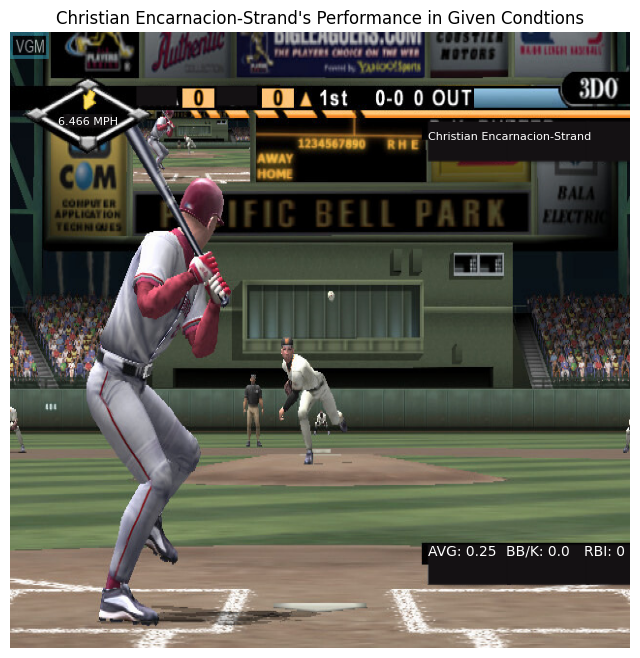

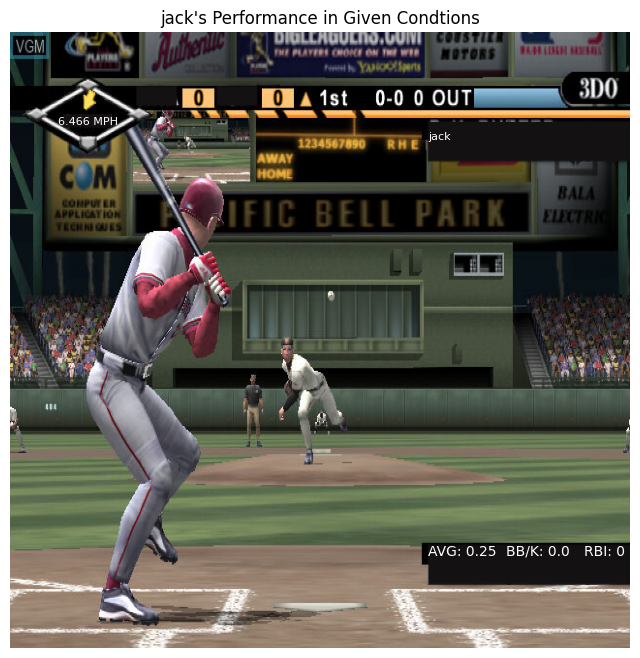

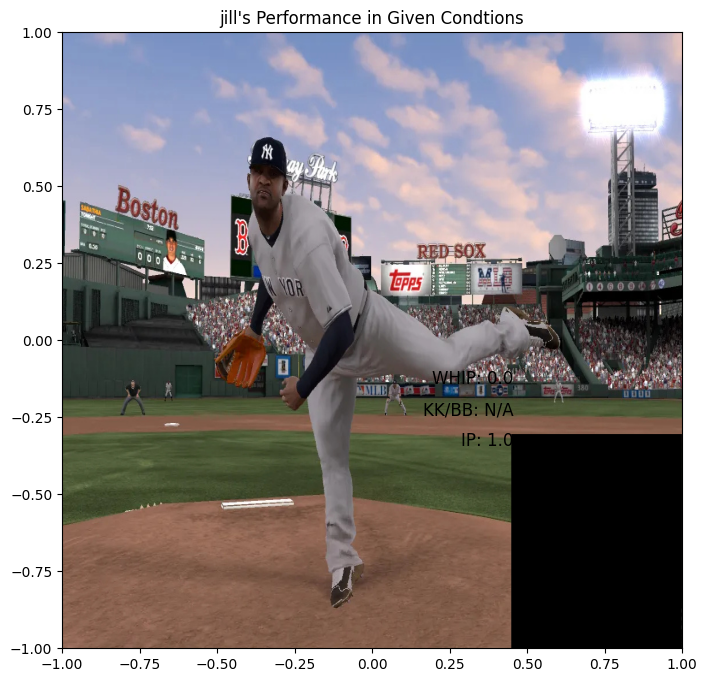

In [20]:
bob = Batter(name="Christian Encarnacion-Strand")
jack = Batter(name='jack')
list(bob)

print(list(bob))


k = batting_model.predict(np.array(list(bob)).reshape(1,-1)).tolist()

print(k)

k = sum(k,[])

print(k)

print(bob.windspeed)
#bob.readout()
bob.compare(jack)
jill = Pitcher(name = 'jill')
jill.readout()



## Player Interface

To start, we will have the user input a player they want to look at. 

In [63]:
name = input("Enter a player's name: ").lower()
player = get_season_avg(name)

C:\Users\skrut\AppData\Local\Temp\ipykernel_8248\2502742489.py:7: DtypeWarning: Columns (15,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  batting_data = pd.read_csv(batting_file)


Now, we will present our user the opportunity to change the environmental factors surrounding the player. 

You can choose which ball park to refer to. If the ballpark is not found, it would state that it is not found.

If you want to do a custom ballpark, you can also input the variables individually for left field, right field, center field distance, and minimum and maximum wall height.

In [64]:
ballpark = input("Enter a ballpark name: ")

player.set_environment_data(ballpark)

In [65]:
print(list(player))

[335.0, 400.0, 325.0, 11.0, 15.0, 29356, 74.41, 6.466, 0.308, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


For our users to input custom data or game specific data, we will have them run this cell.

In [25]:
player.set_custom_ballpark()

In [26]:
print(list(player))

[331.833, 440.0, 200.0, 1.0, 1.0, 29356, 74.41, 6.466, 0.308, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [27]:
player.set_custom_environment()


Day/Night Options: 'day', 'night'

Precipitation Options: 'none', 'rain', ,'drizzle', 'snow'

Sky Options: 'cloudy', 'dome', 'sunny', 'overcast'

Wind Direction Options: 'fromcf', 'fromlf', 'fromrf', 'ltor', 'rtol', 'tocf', 'tolf', 'torf', 'unknown'


In [28]:
print(list(player))


[331.833, 440.0, 200.0, 1.0, 1.0, 1, 1.0, 1.0, 0.308, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
